Выполнила: Ковалева Оксана, БКЛ151

In [1]:
import warnings
warnings.filterwarnings("ignore")

Определение языка (language detection)
--------------------

* **Множество случаев** — тексты на разных языках
* **Множество классов** — языки

В качестве корпусов и текстов для тестирования будем использовать статьи Википедии на разных языках. Скачать Википедию можно различными способами:

* дампы википедии: https://dumps.wikimedia.org/backup-index.html

* wikiextractor: http://medialab.di.unipi.it/wiki/Wikipedia_Extractor

* annotated_wikiextractor: https://github.com/jodaiber/Annotated-WikiExtractor

* wikipedia: https://pypi.python.org/pypi/wikipedia/

#### Скачаем тексты
Воспользуемся пакетом *wikipedia*:

`pip install wikipedia`

In [2]:
def get_texts_for_lang(lang, n=10):
    '''
    Функция для скачивания статей из википедии на определенном языке
    '''
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        except wikipedia.exceptions.WikipediaException:
            print('Skipping page {}'.format(page_name))
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

In [3]:
langs = ['kk', 'uk', 'be', 'fr', 'de', 'it', 'ru']

import wikipedia
import time

def get_texts(langs, n_docs=100):
    '''
    Функция для скачивания определенного количества статей для нескольких языков
    args:
        n_docs: число статей для скачивания
        langs: языки
    '''
    t0 = time.time()

    wiki_texts = {}
    
    for lang in langs: 
        wiki_texts[lang] = get_texts_for_lang(lang, n_docs)
        print(lang, len(wiki_texts[lang]))
        
    print('\nTime passed: ', round((time.time()-t0)/60, 2), 'min') 
    
    return wiki_texts 

In [4]:
wiki_texts = get_texts(langs, 100)

Skipping page Сарытерек ауылдық округі
kk 99
Skipping page Славина
Skipping page Зубрівка (значення)
Skipping page Добробут (значення)
Skipping page Ґірінайчяй
Skipping page Бретяк
Skipping page Золотуха (значення)
Skipping page Лісківська сільська рада
Skipping page Чоленешть
Skipping page Сакура (значення)
Skipping page Іллюшко
Skipping page Провулок Плещеєва
Skipping page СІДЕ
Skipping page Інасікі
uk 87
Skipping page Чарнічнае
Skipping page Шэйка
Skipping page Аўгустова
Skipping page Глядкі (прыпыначны пункт)
Skipping page Междурэчанск
Skipping page Чырвоны Бор
be 94
Skipping page Route 373
Skipping page HLM
Skipping page Rottenberg
Skipping page Silovs
Skipping page Alberndorf
fr 95
Skipping page Ahnapee
Skipping page CKT
Skipping page Cerbu
Skipping page Bundesamt für Zivilschutz
Skipping page Verreaux
Skipping page Art Lake
Skipping page Rudolf Fritz
Skipping page Passagieren
Skipping page Waterville Township
Skipping page Diensbach
Skipping page Gizzi
de 89
Skipping page Soluzi

### Первый метод: частотные слова

#### Немного теории

Очень простой и неплохой по качеству метод. Сначала создаем частотный словарь для всех языков и берем самые частотные слова. После этого для каждого текста, который нам надо расклассифицировать, смотрим, частотных слов какого языка в нем больше - тот язык и выбираем.

Метод неплохо работает на текстах длиннее 50 слов и быстро имлементируется. 

#### Выведем частотный список слов:

In [5]:
import codecs
import collections
import sys
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')

def freq_words(lang):
    '''
    Составим список частотности слов для конкретного языка
    '''
    global wiki_texts
    
    freqs = collections.defaultdict(lambda: 0)
    
    corpus = wiki_texts[lang]
    for article in corpus:
        for word in tokenizer.tokenize(article.replace('\n', '').lower()):
            freqs[word] += 1
    
    return freqs

In [6]:
from copy import deepcopy

def create_dict(n):
    '''
    Вернем объединенный список частотных слов
    n: количество топовых слов
    '''
    words = collections.defaultdict(dict)
    
    # создадим общий список частотных слов в формате 
    # {слово : [языки, где это слово встречается]}
    global wiki_texts
    
    for lang in wiki_texts:
        freqs = freq_words(lang)
        for word in sorted(freqs, key=lambda w: freqs[w], reverse=True)[:n]:
            if not word.isdigit(): 
                if words[word]:
                    words[word].append(lang)
                else:
                    words[word] = [lang]
    
    # отфильтруем общие для разных языков слова
    for i in deepcopy(words):
        if len(words[i]) > 1:
            del words[i]
        
    return words

#### Классификация:

In [7]:
words = create_dict(100)

In [8]:
def lang_det_1(text):
    global words
    global langs
    
    number_of_words = [0 for i in range(len(langs))]
    
    for word in tokenizer.tokenize(text):
        if word in words:
            index = langs.index(words[word][0])
            number_of_words[index] += 1

    return (langs[number_of_words.index(max(number_of_words))])

### Второй метод: частотные символьные n-граммы

Создадим функцию, которая преобразовывает строку в массив n-грамм заданной длины.

In [28]:
from itertools import islice, tee

def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

Теперь создадим частотные словари n-грамм аналогично первому методу.

In [10]:
def freq_ngrams(lang):
    '''
    Составим список частотных ngram для конкретного языка
    '''
    global wiki_texts
    
    freqs_n_grams = collections.defaultdict(lambda: 0)
    
    corpus = wiki_texts[lang]
    for article in corpus:
        for ngram in make_ngrams(article.replace('\n', '').lower()):
            freqs_n_grams[ngram] += 1
    
    return freqs_n_grams



def create_ngrams_dict(n):
    '''
    Вернем объединенный список ngram
    n: количество топовых n-gram
    '''
    n_grams = collections.defaultdict(dict)
    
    global wiki_texts
    
    for lang in wiki_texts:
        freqs = freq_ngrams(lang)
        for ngram in sorted(freqs, key=lambda n: freqs[n], reverse=True)[:n]:
            if n_grams[ngram]:
                n_grams[ngram].append(lang)
            else:
                n_grams[ngram] = [lang]
    
    # отфильтруем общие для разных языков ngram
    for i in deepcopy(n_grams):
        if len(n_grams[i]) > 1:
            del n_grams[i]
        
    return n_grams

Теперь, как и в предыдущем методе, можно загружать готовые частотные словари n-грамм и классифицировать тексты, просто подсчитывая частотные n-граммы в каждом.

In [11]:
n_grams = create_ngrams_dict(100)

In [12]:
def lang_det_2(text):
    global n_grams
    global langs
    
    number_of_ngrams = [0 for i in range(len(langs))]
    
    for ngram in make_ngrams(text):
        if ngram in n_grams:
            index = langs.index(n_grams[ngram][0])
            number_of_ngrams[index] += 1
               
    return (langs[number_of_ngrams.index(max(number_of_ngrams))])

### Результаты:

Скачаем несколько текстов для проверки:

In [14]:
wiki_texts_test = get_texts(langs, 50)

kk 50
Skipping page Бюро (значення)
Skipping page Абдулов
Skipping page Деркачівська волость
Skipping page Немильня
uk 46
Skipping page Друцк (значэнні)
be 49
Skipping page Humber (homonymie)
Skipping page Sigoyer
Skipping page A51
fr 47
Skipping page Alaupović
Skipping page Marcello Bertinetti
Skipping page Illumination
Skipping page Amory Houghton
Skipping page Paul Demiéville
Skipping page Schmige
de 44
Skipping page Guardia Scozzese
it 49
Skipping page Уильям Виндзор
Skipping page Тын
ru 48

Time passed:  12.45 min


In [13]:
def predict_lang(filename):
    return lang_det_1(text), lang_det_2(text)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def metr():
    global wiki_texts_test
    true_labels = []
    predicted_labels_1 = []
    predicted_labels_2 = []

    for lang in wiki_texts_test:
        for text in wiki_texts_test[lang]:
            true_labels.append(lang)
            
            pred_1 = lang_det_1(text)
            predicted_labels_1.append(pred_1)
            
            pred_2 = lang_det_2(text)
            predicted_labels_2.append(pred_2)
            
    return true_labels, predicted_labels_1, predicted_labels_2

In [18]:
true_labels, predicted_labels_1, predicted_labels_2 = metr()

In [19]:
print(classification_report(true_labels, predicted_labels_1))

             precision    recall  f1-score   support

         be       0.98      0.98      0.98        49
         de       1.00      1.00      1.00        44
         fr       1.00      1.00      1.00        47
         it       1.00      1.00      1.00        49
         kk       0.89      1.00      0.94        50
         ru       0.98      0.96      0.97        48
         uk       1.00      0.89      0.94        46

avg / total       0.98      0.98      0.98       333



In [20]:
print(classification_report(true_labels, predicted_labels_2))

             precision    recall  f1-score   support

         be       1.00      1.00      1.00        49
         de       1.00      1.00      1.00        44
         fr       1.00      0.96      0.98        47
         it       1.00      1.00      1.00        49
         kk       1.00      1.00      1.00        50
         ru       1.00      1.00      1.00        48
         uk       0.96      1.00      0.98        46

avg / total       0.99      0.99      0.99       333



Более 'визуальный' вариант:

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap_res(predicted_labels):
    global true_labels
    labels = list(set(true_labels))
    
    fig, ax = plt.subplots()
    sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), annot = True,
                fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title("Confusion matrix")
    plt.show()

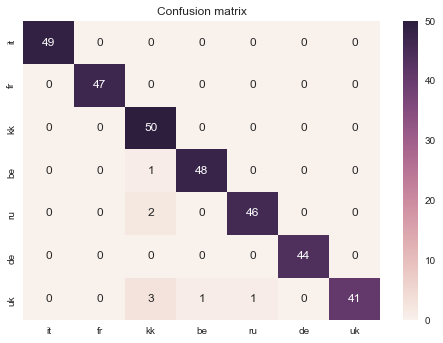

In [22]:
heatmap_res(predicted_labels_1)

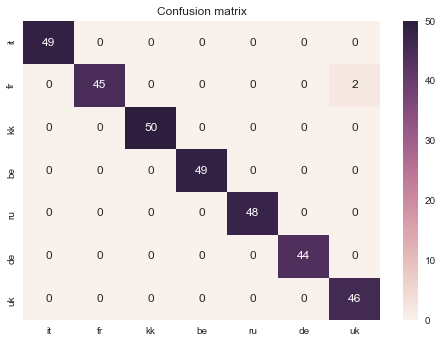

In [23]:
heatmap_res(predicted_labels_2)

## Вывод:

Второй метод показывает несколько лучшие результаты, чем первый.   
Причем с увеличением размера частотного словаря (если мы возьмем более чем по 100 вхождений для каждого языка) качество для второго метода увеличивается незначительно, в то время как первый метод дает все более точные результаты. 

(Однако при очень малом количестве текстов для обучения, первый метод наоборот оказывается менее успешным.)

In [26]:
n_grams = create_ngrams_dict(300)
words = create_dict(300)

true_labels, predicted_labels_1, predicted_labels_2 = metr()

print('Первый метод: частотные слова\n', 
      classification_report(true_labels, predicted_labels_1))
print('Второй метод: частотные символьные 3-граммы\n',
      classification_report(true_labels, predicted_labels_2))

Первый метод: частотные слова
              precision    recall  f1-score   support

         be       1.00      1.00      1.00        49
         de       1.00      1.00      1.00        44
         fr       1.00      1.00      1.00        47
         it       1.00      1.00      1.00        49
         kk       1.00      1.00      1.00        50
         ru       1.00      1.00      1.00        48
         uk       1.00      1.00      1.00        46

avg / total       1.00      1.00      1.00       333

Второй метод: частотные символьные 3-граммы
              precision    recall  f1-score   support

         be       0.98      1.00      0.99        49
         de       0.96      1.00      0.98        44
         fr       0.98      0.98      0.98        47
         it       0.98      0.96      0.97        49
         kk       0.98      1.00      0.99        50
         ru       0.96      0.96      0.96        48
         uk       1.00      0.93      0.97        46

avg / total       

При использовании биграмм вместо триграмм качество заметно падает.  
При использовании n-gram = 4 вместо n-gram = 3 качество также снизилось, хоть и незначительно.

(параметры изменялись в самих кусках кода)

In [27]:
n_grams = create_ngrams_dict(100)

true_labels, predicted_labels_1, predicted_labels_2 = metr()

print('Второй метод: частотные символьные 2-граммы\n',
      classification_report(true_labels, predicted_labels_2))

Второй метод: частотные символьные 2-граммы
              precision    recall  f1-score   support

         be       0.83      1.00      0.91        49
         de       0.96      0.98      0.97        44
         fr       1.00      0.81      0.89        47
         it       0.91      1.00      0.95        49
         kk       0.85      1.00      0.92        50
         ru       0.98      0.85      0.91        48
         uk       0.92      0.72      0.80        46

avg / total       0.92      0.91      0.91       333



In [29]:
n_grams = create_ngrams_dict(100)

true_labels, predicted_labels_1, predicted_labels_2 = metr()

print('Второй метод: частотные символьные 4-граммы\n',
      classification_report(true_labels, predicted_labels_2))

Второй метод: частотные символьные 4-граммы
              precision    recall  f1-score   support

         be       1.00      0.98      0.99        49
         de       1.00      1.00      1.00        44
         fr       1.00      0.96      0.98        47
         it       1.00      1.00      1.00        49
         kk       0.98      1.00      0.99        50
         ru       1.00      1.00      1.00        48
         uk       0.96      1.00      0.98        46

avg / total       0.99      0.99      0.99       333

